# Imports

In [97]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import glob
from datetime import datetime
from statsmodels.tsa.statespace import sarimax
from sklearn.preprocessing import StandardScaler
from math import sqrt

# Reading Time Series from disk

In [98]:
start_time = datetime.now()
all_csv = glob.glob(f'../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/**/*.csv', recursive=True)
end_time = datetime.now()
print(f'Loaded the paths of {len(all_csv)} files from disk. Took {end_time-start_time}')

Loaded the paths of 100 files from disk. Took 0:00:00.001334


# Data Cleaning: Setting Date format

In [99]:
df = pd.read_csv(all_csv[0])
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
df_indexed = df.set_index('timestamp')

# Standardizing Data Values

In [100]:
# prepare data for standardization
values = df_indexed.copy()
values = values.drop(columns=['is_anomaly'],axis=1)
#values = values.reshape((len(values), 1))
# train the standardization
scaler2 = StandardScaler()
scaler2 = scaler2.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler2.mean_, sqrt(scaler2.var_)))
# standardize the dataset
standardaized = scaler2.transform(values)

df['std_value'] = standardaized
df_indexed['std_value'] = standardaized

Mean: 4471.669226, StandardDeviation: 2925.391670


In [103]:
df

,timestamp,value,is_anomaly,std_value
0,2014-11-23 07:00:00,297.829102,0,-1.426763
1,2014-11-23 08:00:00,-16.734937,0,-1.534292
2,2014-11-23 09:00:00,418.295754,0,-1.385583
3,2014-11-23 10:00:00,457.428204,0,-1.372206
4,2014-11-23 11:00:00,311.510876,0,-1.422086
...,...,...,...,...
1416,2015-01-21 07:00:00,8910.889559,0,1.517479
1417,2015-01-21 08:00:00,8130.658688,0,1.250769
1418,2015-01-21 09:00:00,8762.876253,0,1.466883
1419,2015-01-21 10:00:00,9070.204621,0,1.571938


In [104]:
df_indexed

,value,is_anomaly,std_value
timestamp,,,
2014-11-23 07:00:00,297.829102,0,-1.426763
2014-11-23 08:00:00,-16.734937,0,-1.534292
2014-11-23 09:00:00,418.295754,0,-1.385583
2014-11-23 10:00:00,457.428204,0,-1.372206
2014-11-23 11:00:00,311.510876,0,-1.422086
...,...,...,...
2015-01-21 07:00:00,8910.889559,0,1.517479
2015-01-21 08:00:00,8130.658688,0,1.250769
2015-01-21 09:00:00,8762.876253,0,1.466883


# Checking number of Anomalies in Dataset

In [119]:
p = len(df[df.is_anomaly == 1])
n = len(df[df.is_anomaly == 0])

In [107]:
p,n

(9, 1412)

# Creating Models

In [19]:
arima = sarimax.SARIMAX(df.std_value,order=(7,1,7),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,)

AR = sarimax.SARIMAX(df.std_value,order=(1,0,0),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,)

MA = sarimax.SARIMAX(df.std_value,order=(0,0,1),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,)

model = arima.fit()

model2 = AR.fit()

model3 = MA.fit()

In [39]:
model.predict()

0       0.000000
1      -1.371806
2      -1.793672
3      -1.279702
4      -1.152371
          ...   
1416    1.500784
1417    1.527776
1418    1.356042
1419    1.460975
1420    1.709659
Length: 1421, dtype: float64

In [40]:
df1 = model.predict()

In [41]:
model2.predict()

0       0.000000
1      -1.344179
2      -1.445484
3      -1.305383
4      -1.292780
          ...   
1416    1.380607
1417    1.429644
1418    1.178372
1419    1.381977
1420    1.480951
Length: 1421, dtype: float64

In [42]:
df2 = model2.predict()

In [43]:
model3.predict()

0       0.000000e+00
1       0.000000e+00
2      -4.724783e-07
3      -6.607277e-01
4      -4.391310e-01
            ...     
1416    5.720497e-01
1417    6.932199e-01
1418    4.088134e-01
1419    7.758115e-01
1420    5.837465e-01
Length: 1421, dtype: float64

In [44]:
df3 = model3.predict()

In [ ]:
plt

# Plotting Models

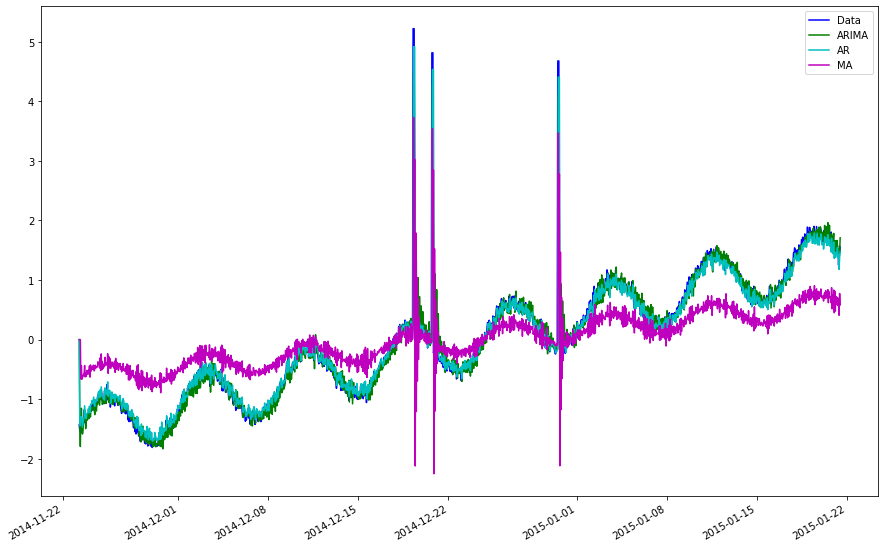

In [83]:
plt.rcParams.update({'figure.figsize': (15,10)})
plt.plot_date(df['timestamp'],np.asarray(df['std_value']),'b-')

plt.plot_date(df['timestamp'],np.asarray(df1), 'g-')

plt.plot_date(df['timestamp'],np.asarray(df2), 'c-')

plt.plot_date(df['timestamp'],np.asarray(df3), 'm-')

plt.xlabel="Date"
plt.ylabel="Server Traffic"
plt.gcf().autofmt_xdate()
plt.legend(('Data','ARIMA', 'AR', 'MA'))
#plt.legend()

# Calculating confusion matrix 

In [68]:
comparisonmatrix = pd.concat([df,df1,df2,df3],axis = 1) #, on='timestamp',how='inner',lsuffix='_data',rsuffix='_predict')

In [75]:
comparisonmatrix.rename(columns={0:'ARIMAval'},inplace=True)
comparisonmatrix.rename(columns={1:'ARval'},inplace=True)
comparisonmatrix.rename(columns={2:'MAval'},inplace=True)
comparisonmatrix

,timestamp,value,is_anomaly,std_value,ARIMAval,ARval,MAval
0,2014-11-23 07:00:00,297.829102,0,-1.426763,0.000000,0.000000,0.000000e+00
1,2014-11-23 08:00:00,-16.734937,0,-1.534292,-1.371806,-1.344179,0.000000e+00
2,2014-11-23 09:00:00,418.295754,0,-1.385583,-1.793672,-1.445484,-4.724783e-07
3,2014-11-23 10:00:00,457.428204,0,-1.372206,-1.279702,-1.305383,-6.607277e-01
4,2014-11-23 11:00:00,311.510876,0,-1.422086,-1.152371,-1.292780,-4.391310e-01
...,...,...,...,...,...,...,...
1416,2015-01-21 07:00:00,8910.889559,0,1.517479,1.500784,1.380607,5.720497e-01
1417,2015-01-21 08:00:00,8130.658688,0,1.250769,1.527776,1.429644,6.932199e-01
1418,2015-01-21 09:00:00,8762.876253,0,1.466883,1.356042,1.178372,4.088134e-01
1419,2015-01-21 10:00:00,9070.204621,0,1.571938,1.460975,1.381977,7.758115e-01


In [76]:
#manual threshold set
threshold = 1.0

#compare the real df value with the AR model and then 
arimaoutliers = comparisonmatrix[comparisonmatrix.std_value > comparisonmatrix.ARIMAval + threshold]
aroutliers = comparisonmatrix[comparisonmatrix.std_value > comparisonmatrix.ARval + threshold]
maoutliers = comparisonmatrix[comparisonmatrix.std_value > comparisonmatrix.MAval + threshold]

In [77]:
arimaoutliers

,timestamp,value,is_anomaly,std_value,ARIMAval,ARval,MAval
623,2014-12-19 06:00:00,19740.188389,1,5.219308,0.185505,0.181543,0.134304
658,2014-12-20 17:00:00,18553.830928,1,4.813770,-0.042722,-0.033349,-0.017817
893,2014-12-30 12:00:00,18153.623148,1,4.676965,-0.151964,-0.156304,-0.053368


In [78]:
aroutliers

,timestamp,value,is_anomaly,std_value,ARIMAval,ARval,MAval
623,2014-12-19 06:00:00,19740.188389,1,5.219308,0.185505,0.181543,0.134304
658,2014-12-20 17:00:00,18553.830928,1,4.813770,-0.042722,-0.033349,-0.017817
893,2014-12-30 12:00:00,18153.623148,1,4.676965,-0.151964,-0.156304,-0.053368


In [96]:
df.iloc[623:626]

,timestamp,value,is_anomaly,std_value
623,2014-12-19 06:00:00,19740.188389,1,5.219308
624,2014-12-19 07:00:00,19740.188389,1,5.219308
625,2014-12-19 08:00:00,19740.188389,1,5.219308


In [79]:
maoutliers

,timestamp,value,is_anomaly,std_value,ARIMAval,ARval,MAval
623,2014-12-19 06:00:00,19740.188389,1,5.219308,0.185505,0.181543,0.134304
624,2014-12-19 07:00:00,19740.188389,1,5.219308,4.458260,4.917203,3.728492
625,2014-12-19 08:00:00,19740.188389,1,5.219308,4.770588,4.917203,1.093115
627,2014-12-19 10:00:00,5419.457614,0,0.323987,-0.032279,0.125779,-2.120476
629,2014-12-19 12:00:00,5096.654600,0,0.213642,1.326559,0.137115,-1.207504
658,2014-12-20 17:00:00,18553.830928,1,4.813770,-0.042722,-0.033349,-0.017817
659,2014-12-20 18:00:00,18553.830928,1,4.813770,4.233133,4.535138,3.542678
660,2014-12-20 19:00:00,18553.830928,1,4.813770,4.354867,4.535138,0.932006
662,2014-12-20 21:00:00,3967.320927,0,-0.172404,-0.285647,-0.210973,-2.251152
893,2014-12-30 12:00:00,18153.623148,1,4.676965,-0.151964,-0.156304,-0.053368


In [84]:
arimanot_outliers = comparisonmatrix.merge(arimaoutliers, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'] 
arnot_outliers = comparisonmatrix.merge(aroutliers, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'] 
manot_outliers = comparisonmatrix.merge(maoutliers, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'] 

In [87]:
arimaoutliers

,timestamp,value,is_anomaly,std_value,ARIMAval,ARval,MAval
623,2014-12-19 06:00:00,19740.188389,1,5.219308,0.185505,0.181543,0.134304
658,2014-12-20 17:00:00,18553.830928,1,4.813770,-0.042722,-0.033349,-0.017817
893,2014-12-30 12:00:00,18153.623148,1,4.676965,-0.151964,-0.156304,-0.053368


In [88]:
arimanot_outliers

,timestamp,value,is_anomaly,std_value,ARIMAval,ARval,MAval,_merge
0,2014-11-23 07:00:00,297.829102,0,-1.426763,0.000000,0.000000,0.000000e+00,left_only
1,2014-11-23 08:00:00,-16.734937,0,-1.534292,-1.371806,-1.344179,0.000000e+00,left_only
2,2014-11-23 09:00:00,418.295754,0,-1.385583,-1.793672,-1.445484,-4.724783e-07,left_only
3,2014-11-23 10:00:00,457.428204,0,-1.372206,-1.279702,-1.305383,-6.607277e-01,left_only
4,2014-11-23 11:00:00,311.510876,0,-1.422086,-1.152371,-1.292780,-4.391310e-01,left_only
...,...,...,...,...,...,...,...,...
1416,2015-01-21 07:00:00,8910.889559,0,1.517479,1.500784,1.380607,5.720497e-01,left_only
1417,2015-01-21 08:00:00,8130.658688,0,1.250769,1.527776,1.429644,6.932199e-01,left_only
1418,2015-01-21 09:00:00,8762.876253,0,1.466883,1.356042,1.178372,4.088134e-01,left_only
1419,2015-01-21 10:00:00,9070.204621,0,1.571938,1.460975,1.381977,7.758115e-01,left_only


In [92]:
arimatruepositives = arimaoutliers[arimaoutliers['is_anomaly'] == 1]
arimafalsepostives = arimaoutliers[arimaoutliers['is_anomaly'] == 0]

In [93]:
artruepositives = aroutliers[aroutliers['is_anomaly'] == 1]
arfalsepostives = aroutliers[aroutliers['is_anomaly'] == 0]

In [94]:
matruepositives = maoutliers[maoutliers['is_anomaly'] == 1]
mafalsepostives = maoutliers[maoutliers['is_anomaly'] == 0]

In [95]:
arimatruepositives,artruepositives, matruepositives

(              timestamp         value  is_anomaly  std_value  ARIMAval  \
 623 2014-12-19 06:00:00  19740.188389           1   5.219308  0.185505   
 658 2014-12-20 17:00:00  18553.830928           1   4.813770 -0.042722   
 893 2014-12-30 12:00:00  18153.623148           1   4.676965 -0.151964   
 
         ARval     MAval  
 623  0.181543  0.134304  
 658 -0.033349 -0.017817  
 893 -0.156304 -0.053368  ,
               timestamp         value  is_anomaly  std_value  ARIMAval  \
 623 2014-12-19 06:00:00  19740.188389           1   5.219308  0.185505   
 658 2014-12-20 17:00:00  18553.830928           1   4.813770 -0.042722   
 893 2014-12-30 12:00:00  18153.623148           1   4.676965 -0.151964   
 
         ARval     MAval  
 623  0.181543  0.134304  
 658 -0.033349 -0.017817  
 893 -0.156304 -0.053368  ,
               timestamp         value  is_anomaly  std_value  ARIMAval  \
 623 2014-12-19 06:00:00  19740.188389           1   5.219308  0.185505   
 624 2014-12-19 07:00:00  19

In [108]:
arimafalsepostives, arfalsepostives, mafalsepostives

(Empty DataFrame
 Columns: [timestamp, value, is_anomaly, std_value, ARIMAval, ARval, MAval]
 Index: [],
 Empty DataFrame
 Columns: [timestamp, value, is_anomaly, std_value, ARIMAval, ARval, MAval]
 Index: [],
                timestamp         value  is_anomaly  std_value  ARIMAval  \
 627  2014-12-19 10:00:00   5419.457614           0   0.323987 -0.032279   
 629  2014-12-19 12:00:00   5096.654600           0   0.213642  1.326559   
 662  2014-12-20 21:00:00   3967.320927           0  -0.172404 -0.285647   
 897  2014-12-30 16:00:00   4130.332895           0  -0.116681 -0.240771   
 1172 2015-01-11 03:00:00   8844.085897           0   1.494643  1.397185   
 1179 2015-01-11 10:00:00   8935.935476           0   1.526041  1.297244   
 1206 2015-01-12 13:00:00   8614.645939           0   1.416213  1.249596   
 1343 2015-01-18 06:00:00   9121.749114           0   1.589558  1.370499   
 1348 2015-01-18 11:00:00   9386.695291           0   1.680126  1.550902   
 1350 2015-01-18 13:00:00   95

In [110]:
arimatruenegatives=arimanot_outliers[arimanot_outliers['is_anomaly'] == 0]
arimafalsenegatives = arimanot_outliers[arimanot_outliers['is_anomaly'] == 1]

artruenegatives=arnot_outliers[arnot_outliers['is_anomaly'] == 0]
arfalsenegatives = arnot_outliers[arnot_outliers['is_anomaly'] == 1]

matruenegatives=manot_outliers[manot_outliers['is_anomaly'] == 0]
mafalsenegatives = manot_outliers[manot_outliers['is_anomaly'] == 1]

In [116]:
if(len(arimatruepositives) + len(arimafalsepostives) > 0):
    arimaprecision = len(arimatruepositives)/(len(arimatruepositives) + len(arimafalsepostives))
    print("Precision: ", arimaprecision)
    arimaprecision_plot.append(arimaprecision)
else:
    print("truepositives + falsepositives = 0")
    arimaprecision_plot.append(0)
    #continue

if(len(arimatruepositives) + len(arimafalsenegatives) > 0):
    arimarecall = len(arimatruepositives)/(len(arimatruepositives) + len(arimafalsenegatives))
    print("Recall:", arimarecall)
    arimarecall_plot.append(arimarecall)
else:
    print("truepositives + falsenegatives = 0")
    arimarecall_plot.append(0)
    #continue   

if(arimaprecision + arimarecall > 0):
    f1 = 2*(arimaprecision * arimarecall)/(arimaprecision + recaarimarecallll)
    print("F1:",f1)
    arimaf1_plot.append(f1)
else:
    print("precision + recall = 0")
    arimaf1_plot.append(0)
    #continue
print("--------------------")

Precision:  1.0


NameError: name 'arimaprecision_plot' is not defined

# Loop

In [117]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import glob
from datetime import datetime
from statsmodels.tsa.statespace import sarimax
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [118]:
start_time = datetime.now()
all_csv = glob.glob(f'../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/**/*.csv', recursive=True)
end_time = datetime.now()
print(f'Loaded the paths of {len(all_csv)} files from disk. Took {end_time-start_time}')

Loaded the paths of 100 files from disk. Took 0:00:00.001283


Processing index: 0 of 100



Mean: 4471.669226, StandardDeviation: 2925.391670


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


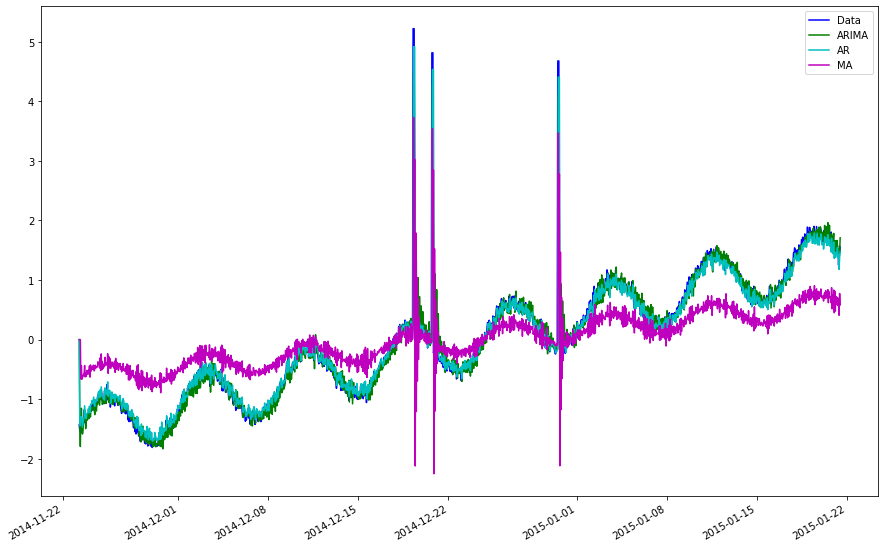

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:9 | False Positive: 40
Negative:False Negative:0 |True Negative: 1372
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412



Mean: 281.561558, StandardDeviation: 1014.996111


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


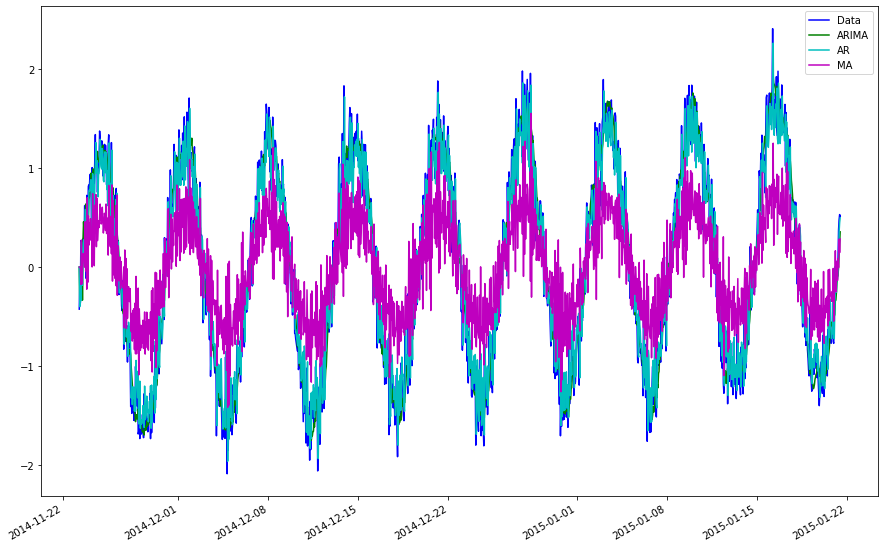

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:0 | False Positive: 3
Negative:False Negative:1 |True Negative: 1417
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:0 | False Positive: 89
Negative:False Negative:1 |True Negative: 1331
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420



Mean: 3211.798426, StandardDeviation: 2136.444375


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


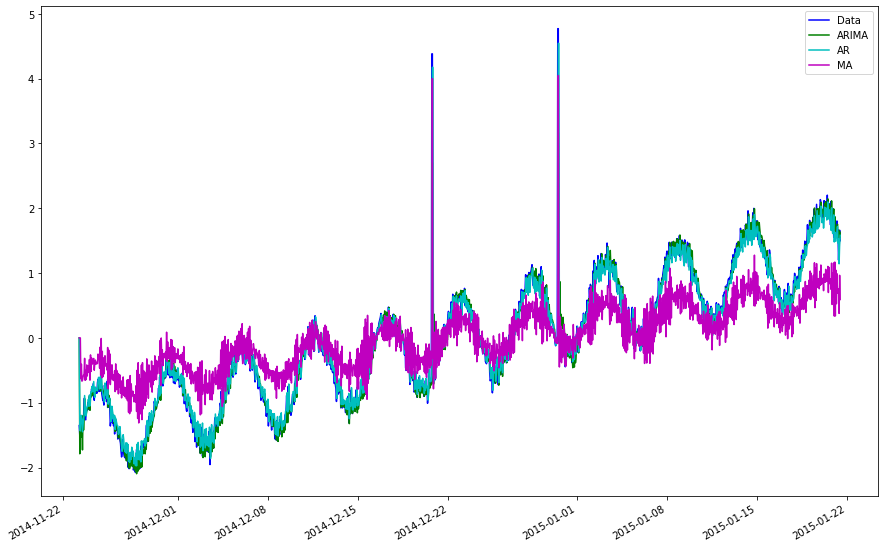

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:4 | False Positive: 0
Negative:False Negative:0 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 55
Negative:False Negative:2 |True Negative: 1362
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417



Mean: 677.021695, StandardDeviation: 1078.857833


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


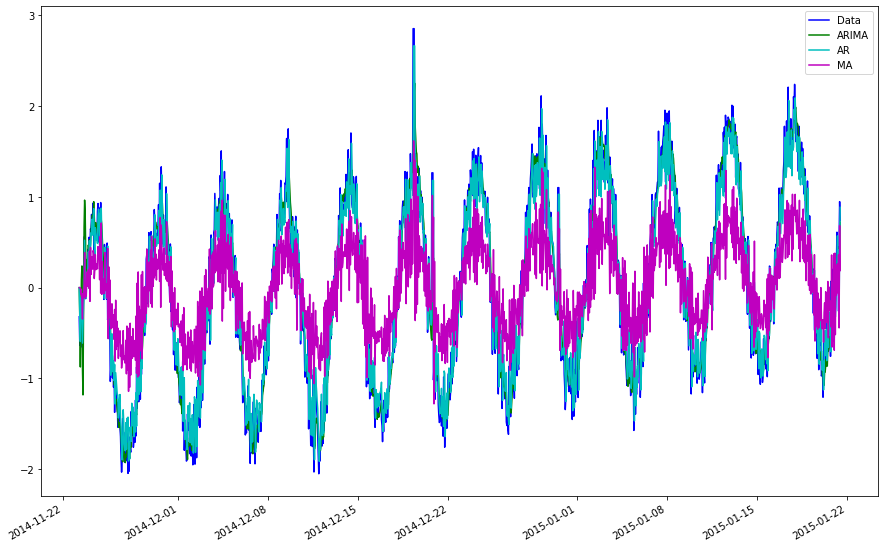

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:7 | False Positive: 0
Negative:False Negative:2 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 4
Negative:False Negative:6 |True Negative: 1408
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:6 | False Positive: 100
Negative:False Negative:3 |True Negative: 1312
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412



Mean: 2841.957725, StandardDeviation: 1929.904148


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


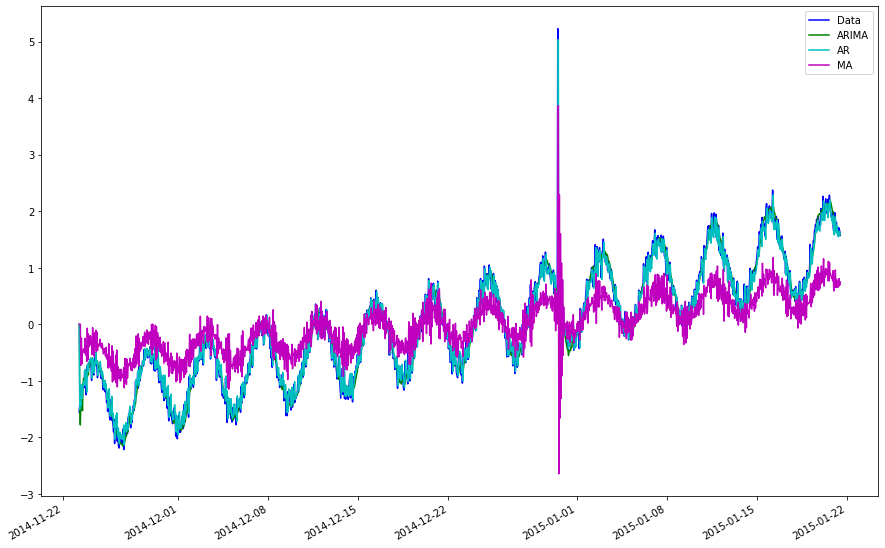

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 79
Negative:False Negative:0 |True Negative: 1341
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420
Processing index: 5 of 100



Mean: 9202.203480, StandardDeviation: 5383.176339


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


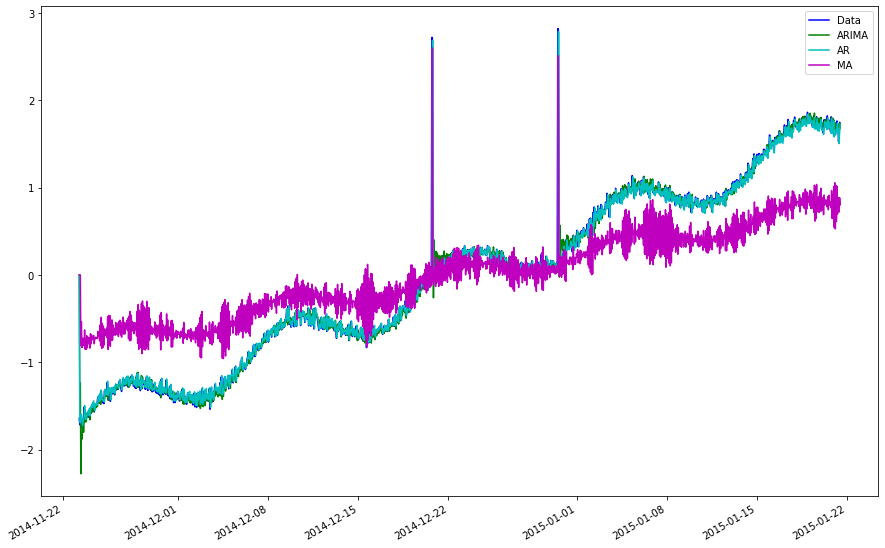

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 21
Negative:False Negative:2 |True Negative: 1396
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417



Mean: 853.154308, StandardDeviation: 1095.773774


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


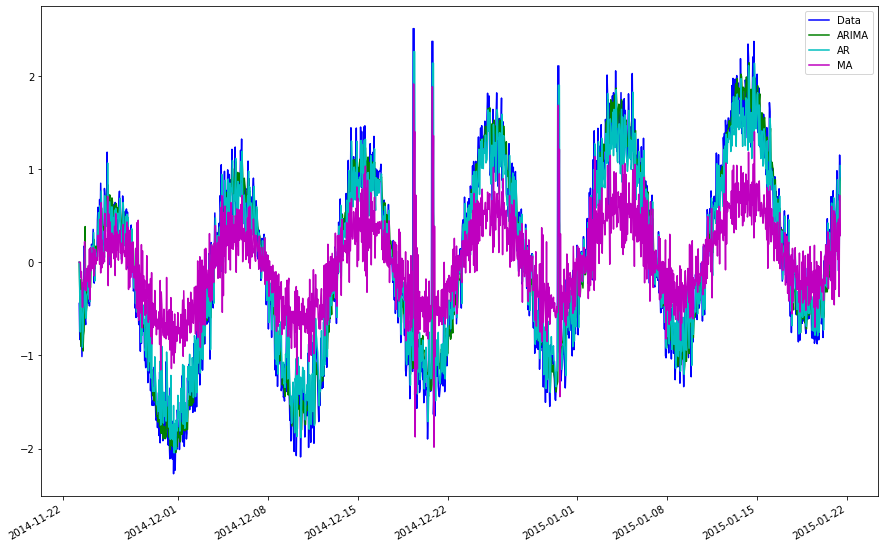

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:9 | False Positive: 0
Negative:False Negative:0 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 6
Negative:False Negative:6 |True Negative: 1406
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:6 | False Positive: 97
Negative:False Negative:3 |True Negative: 1315
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412



Mean: 5.536843, StandardDeviation: 989.172534


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


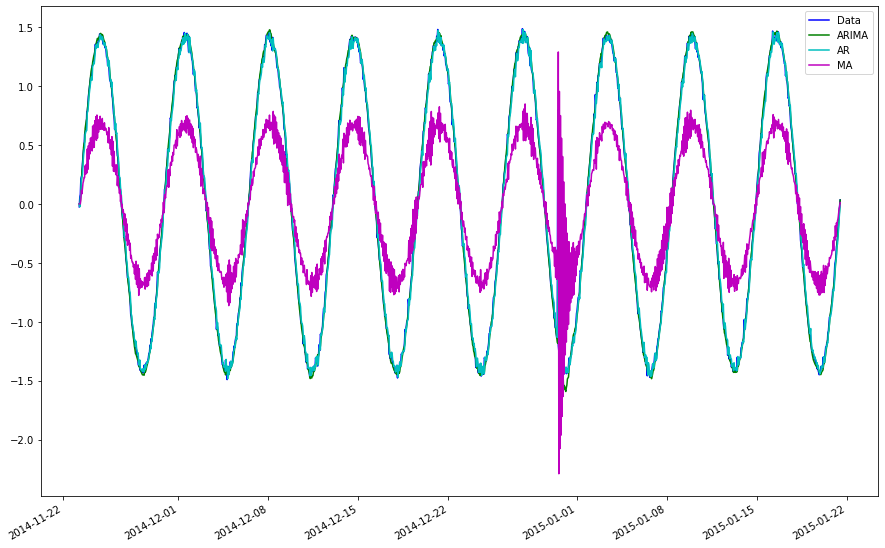

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 1
Negative:False Negative:0 |True Negative: 1419
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420



Mean: 5950.417354, StandardDeviation: 3552.981132


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


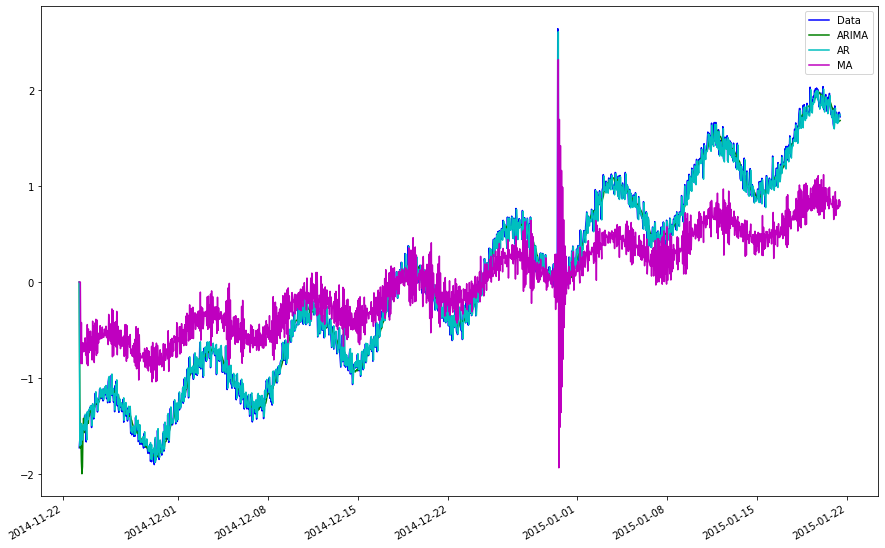

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 40
Negative:False Negative:0 |True Negative: 1380
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420



Mean: 959.394771, StandardDeviation: 1155.849408


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


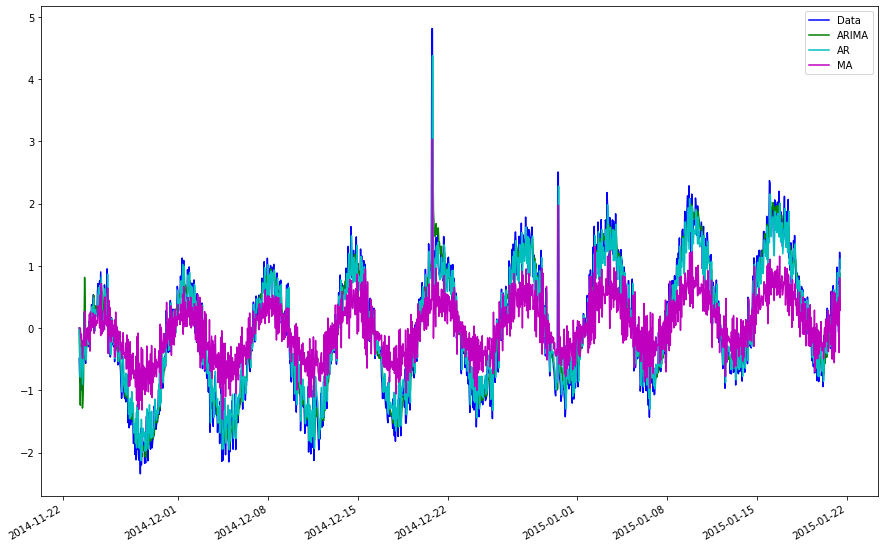

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:4 | False Positive: 0
Negative:False Negative:0 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 8
Negative:False Negative:2 |True Negative: 1409
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 101
Negative:False Negative:1 |True Negative: 1316
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417
Processing index: 10 of 100



Mean: 3878.769478, StandardDeviation: 2453.291769


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


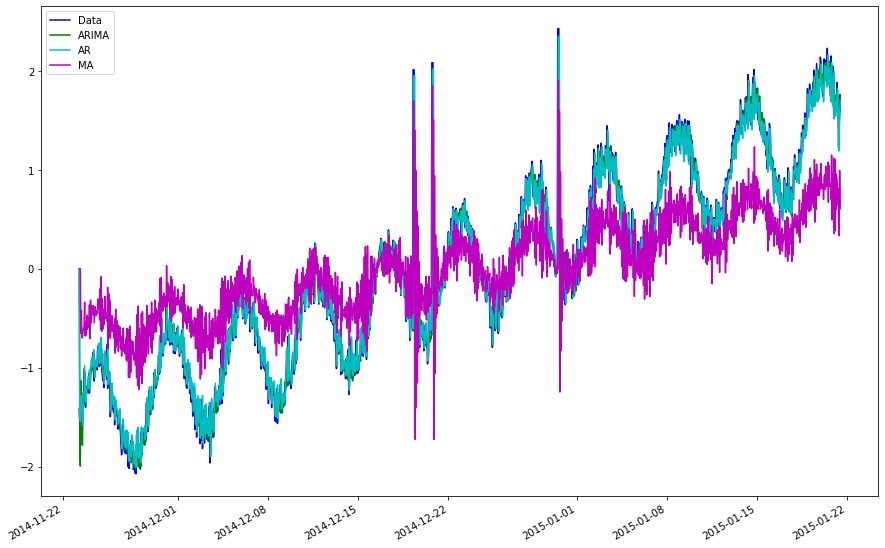

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:4 | False Positive: 0
Negative:False Negative:5 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:6 | False Positive: 70
Negative:False Negative:3 |True Negative: 1342
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412



Mean: 533.967462, StandardDeviation: 1069.884522


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


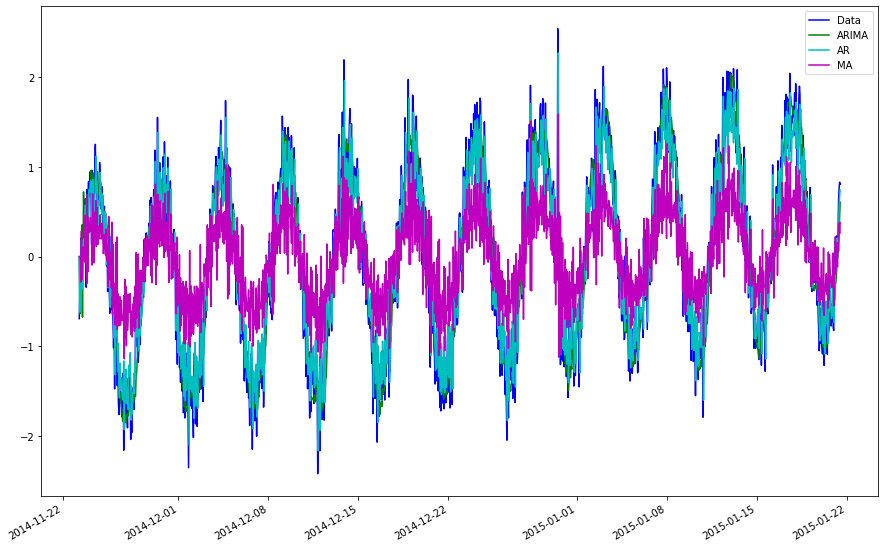

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 3
Negative:False Negative:0 |True Negative: 1417
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 21
Negative:False Negative:0 |True Negative: 1399
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 113
Negative:False Negative:0 |True Negative: 1307
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420



Mean: 2873.685166, StandardDeviation: 1957.027297


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


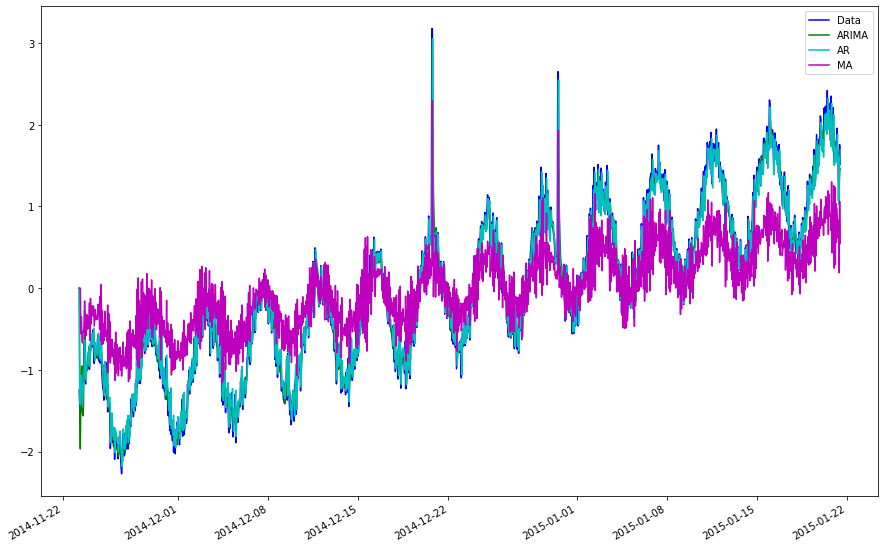

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:4 | False Positive: 0
Negative:False Negative:0 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 83
Negative:False Negative:2 |True Negative: 1334
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417



Mean: 11410.899789, StandardDeviation: 7069.718250


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


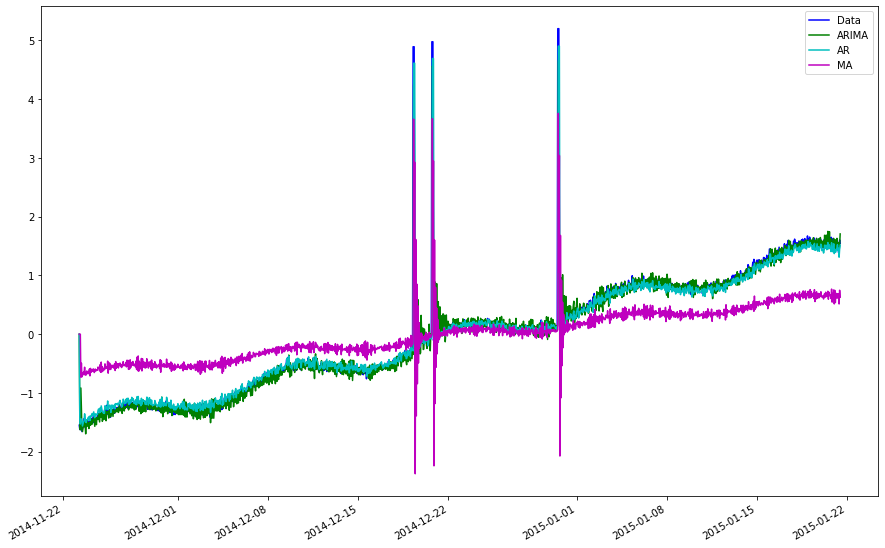

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:9 | False Positive: 14
Negative:False Negative:0 |True Negative: 1398
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412



Mean: 634.296881, StandardDeviation: 1095.076584


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


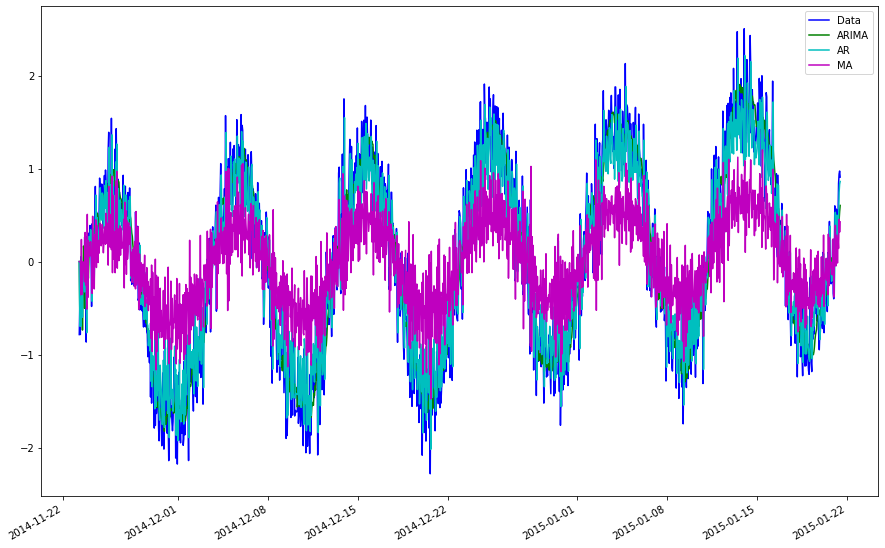

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 2
Negative:False Negative:0 |True Negative: 1418
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:0 | False Positive: 26
Negative:False Negative:1 |True Negative: 1394
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:0 | False Positive: 123
Negative:False Negative:1 |True Negative: 1297
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420
Processing index: 15 of 100



Mean: 6556.232773, StandardDeviation: 4013.701672


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


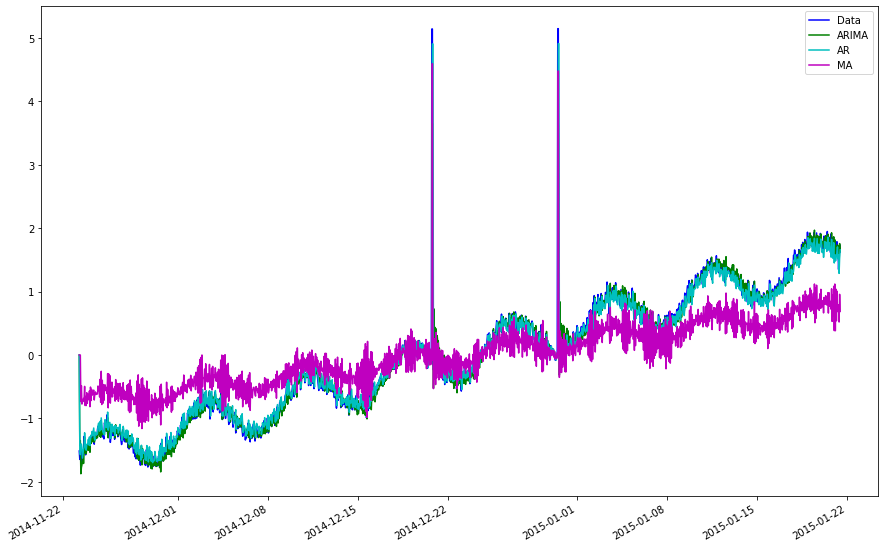

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:4 | False Positive: 0
Negative:False Negative:0 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 31
Negative:False Negative:2 |True Negative: 1386
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417



Mean: 1442.278105, StandardDeviation: 1306.683693


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


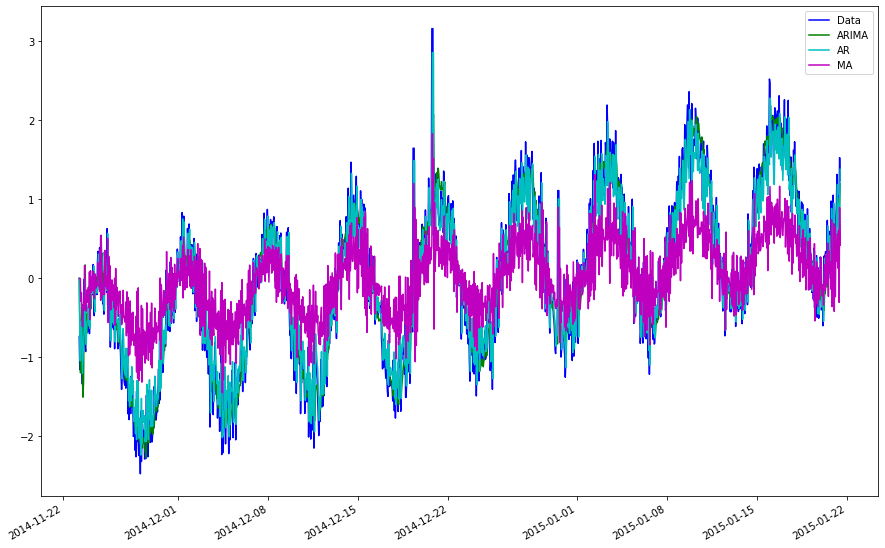

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:9 | False Positive: 0
Negative:False Negative:0 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 12
Negative:False Negative:6 |True Negative: 1400
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:6 | False Positive: 110
Negative:False Negative:3 |True Negative: 1302
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412



Mean: 5179.096630, StandardDeviation: 3173.156284


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


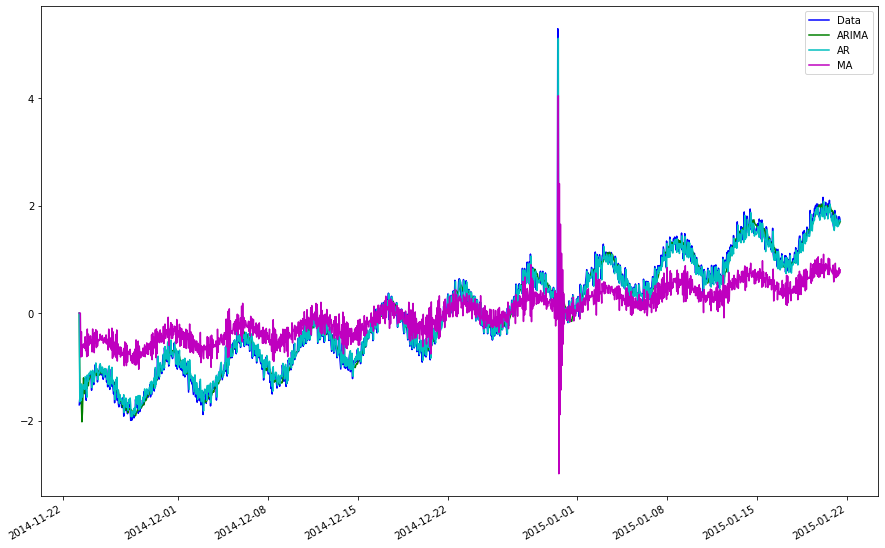

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 60
Negative:False Negative:0 |True Negative: 1360
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420



Mean: 632.735854, StandardDeviation: 1043.469684


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


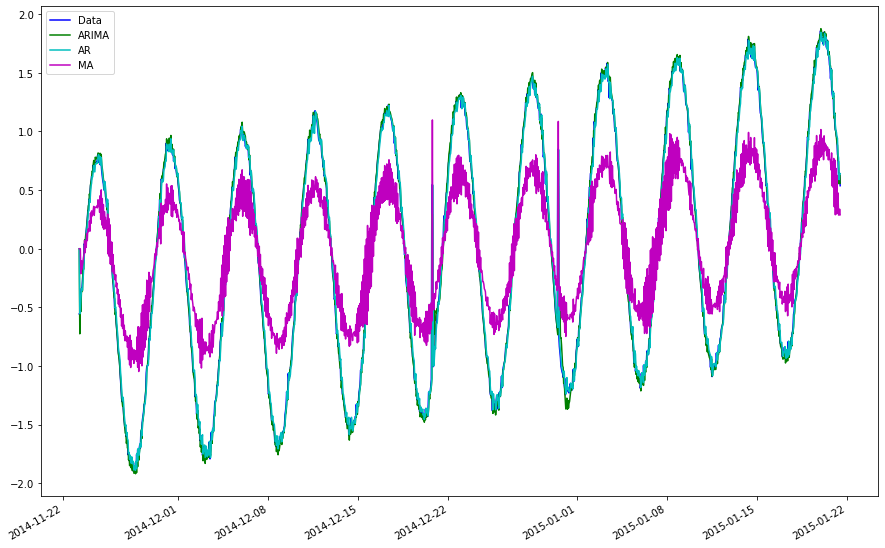

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 10
Negative:False Negative:2 |True Negative: 1407
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417



Mean: 1588.069123, StandardDeviation: 1364.684820


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


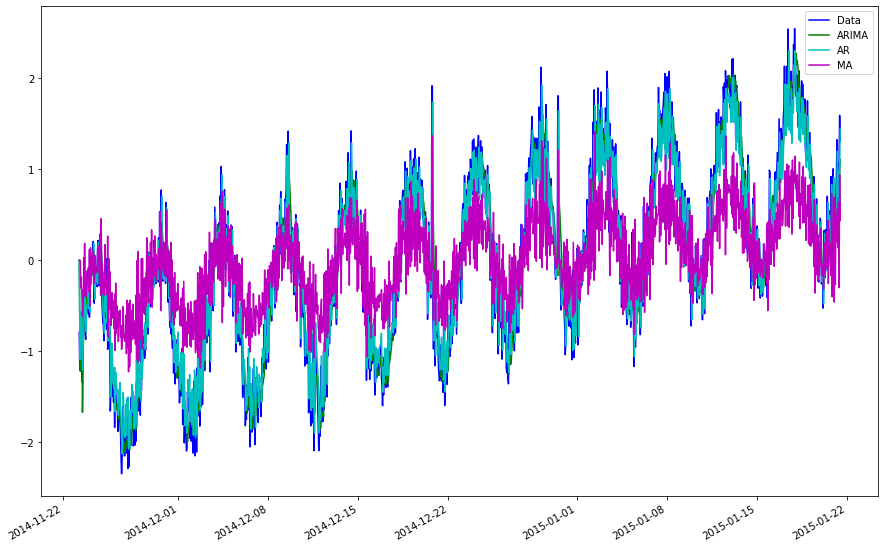

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:4 | False Positive: 1
Negative:False Negative:0 |True Negative: 1416
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 11
Negative:False Negative:2 |True Negative: 1406
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 114
Negative:False Negative:2 |True Negative: 1303
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417
Processing index: 20 of 100



Mean: 3224.960580, StandardDeviation: 2265.218133


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


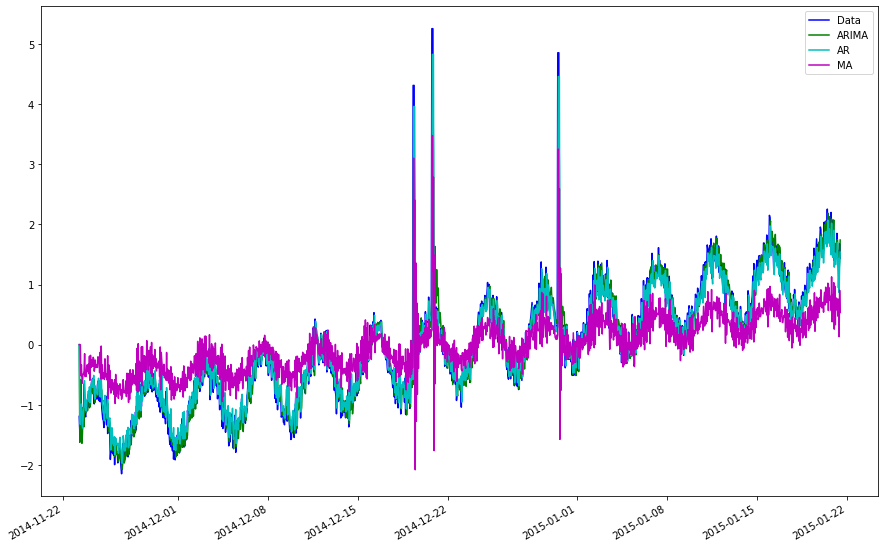

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:6 | False Positive: 0
Negative:False Negative:3 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:9 | False Positive: 76
Negative:False Negative:0 |True Negative: 1336
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412



Mean: 14015.791325, StandardDeviation: 8113.068457


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


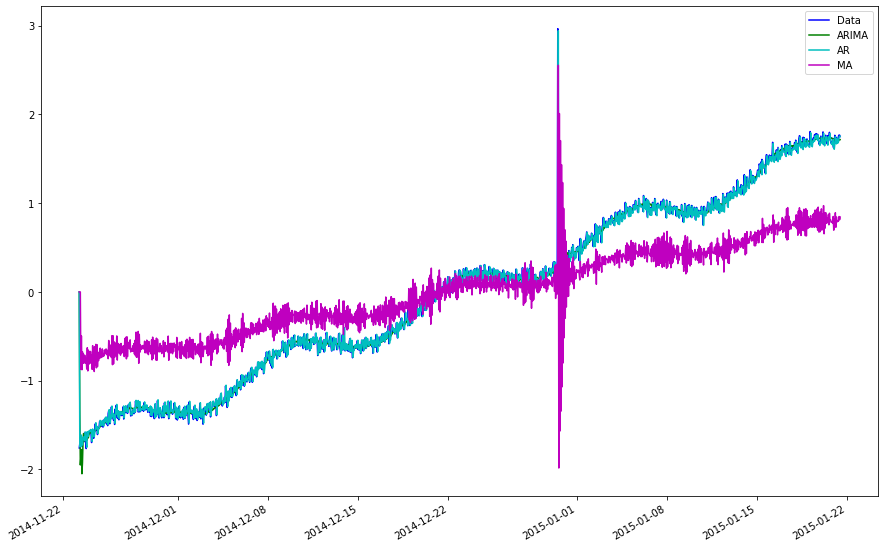

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 28
Negative:False Negative:0 |True Negative: 1392
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420



Mean: 1844.380800, StandardDeviation: 1439.541406


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


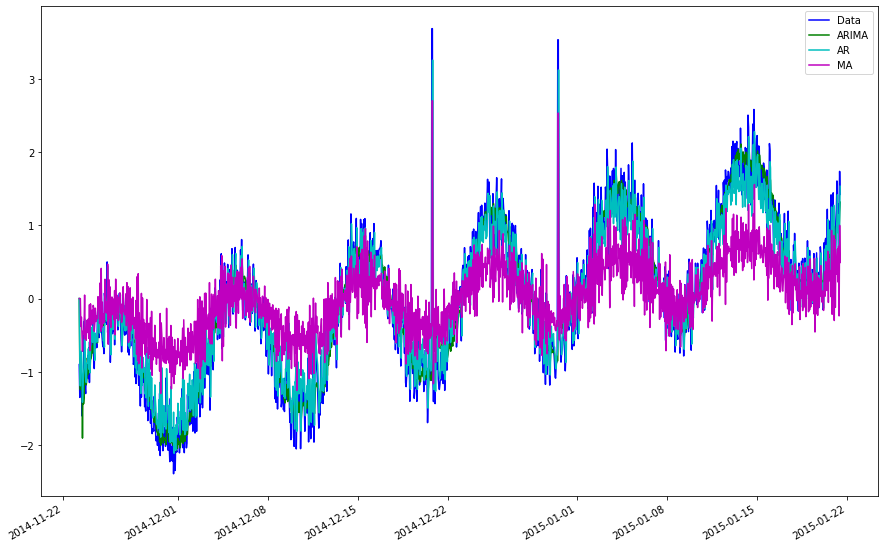

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:4 | False Positive: 2
Negative:False Negative:0 |True Negative: 1415
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 16
Negative:False Negative:2 |True Negative: 1401
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 112
Negative:False Negative:2 |True Negative: 1305
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417



Mean: 7485.049903, StandardDeviation: 4477.502832


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


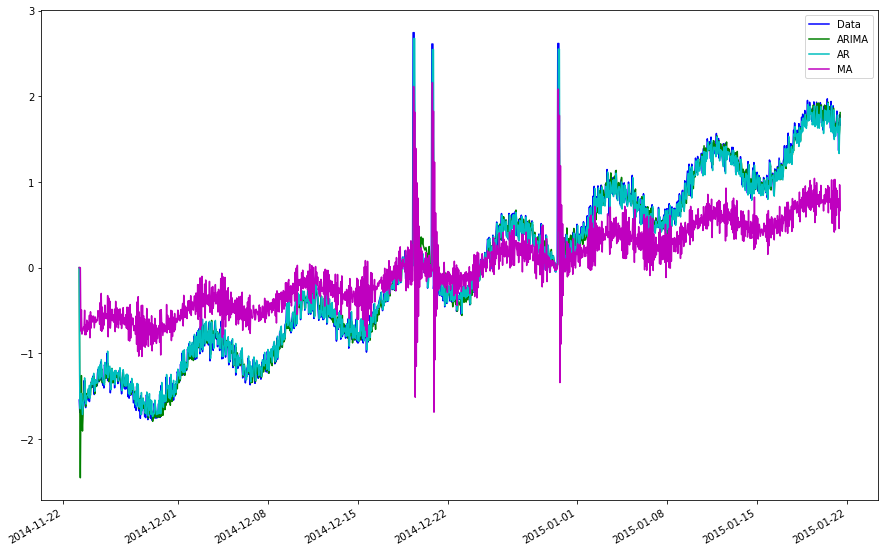

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:6 | False Positive: 38
Negative:False Negative:3 |True Negative: 1374
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412



Mean: 993.259043, StandardDeviation: 1187.711162


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


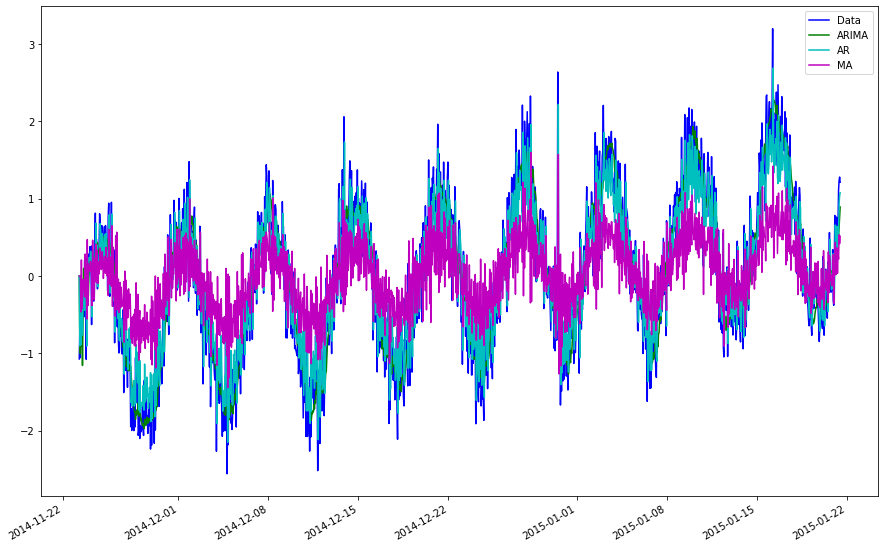

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 14
Negative:False Negative:0 |True Negative: 1406
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 43
Negative:False Negative:0 |True Negative: 1377
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 134
Negative:False Negative:0 |True Negative: 1286
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420
Processing index: 25 of 100



Mean: 556.168299, StandardDeviation: 1032.250432


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


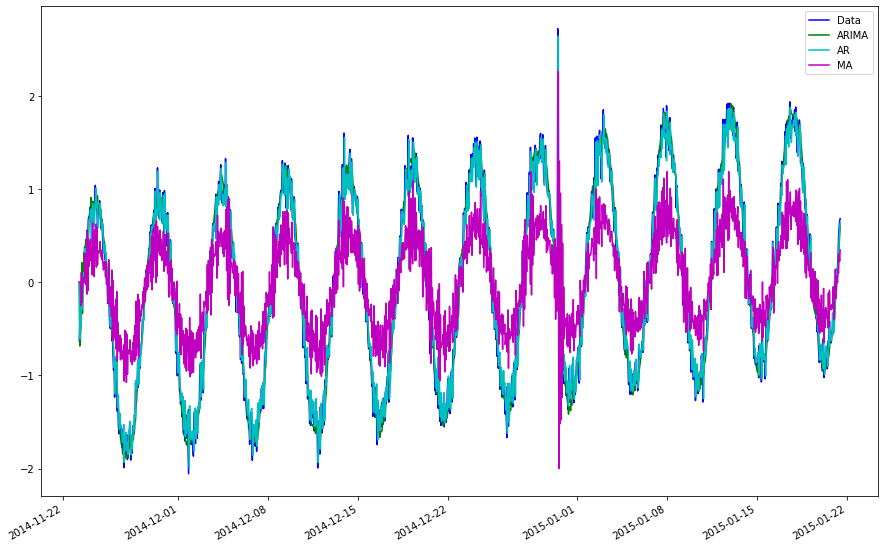

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 65
Negative:False Negative:0 |True Negative: 1355
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420



Mean: 7759.722960, StandardDeviation: 4605.211318


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


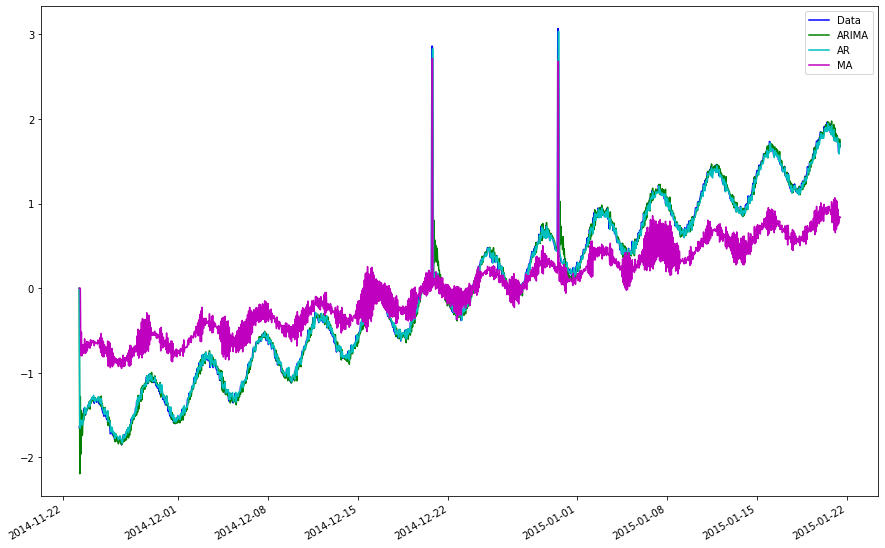

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 16
Negative:False Negative:2 |True Negative: 1401
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417



Mean: 26401.054954, StandardDeviation: 16295.078570


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


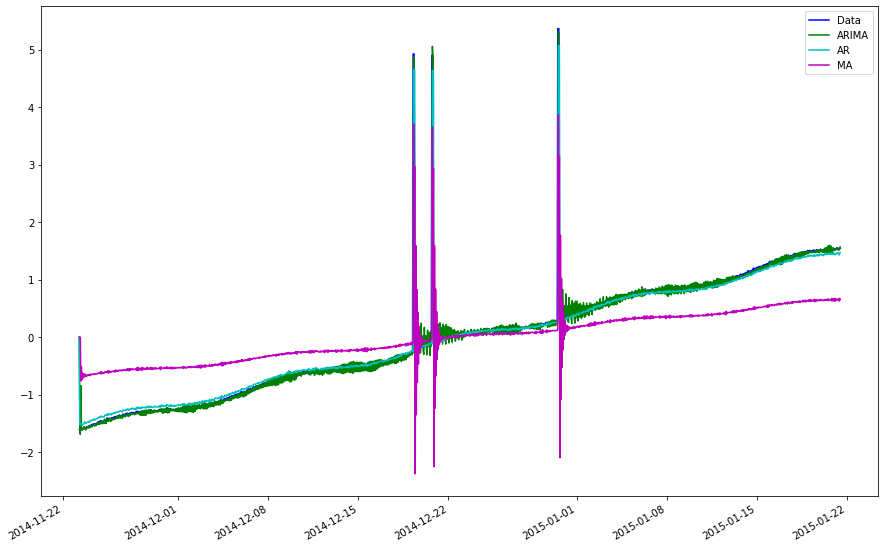

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:9 | False Positive: 6
Negative:False Negative:0 |True Negative: 1406
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412



Mean: 691.874740, StandardDeviation: 1044.758674


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


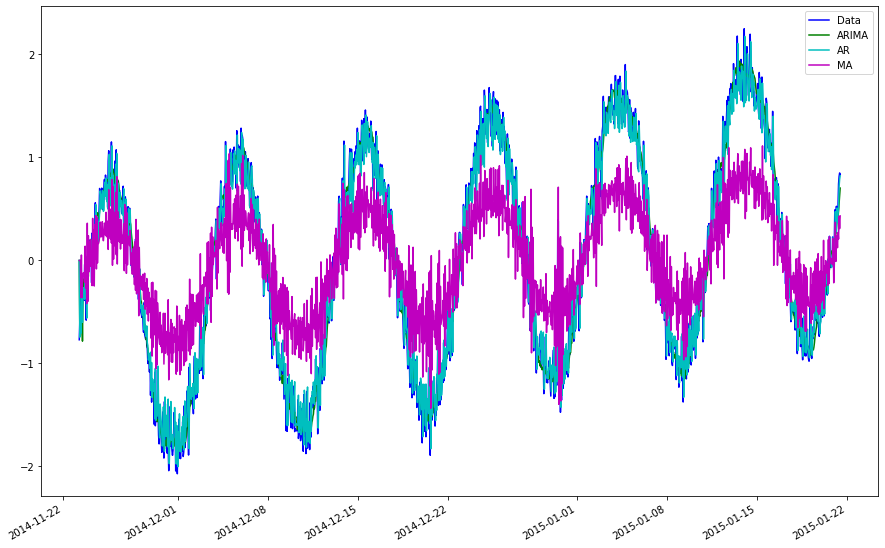

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:1 | False Positive: 0
Negative:False Negative:0 |True Negative: 1420
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:0 | False Positive: 61
Negative:False Negative:1 |True Negative: 1359
Total Positives(Anomalies):1 | Total Negatives(Regulars): 1420



Mean: 15368.062661, StandardDeviation: 9186.095179


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


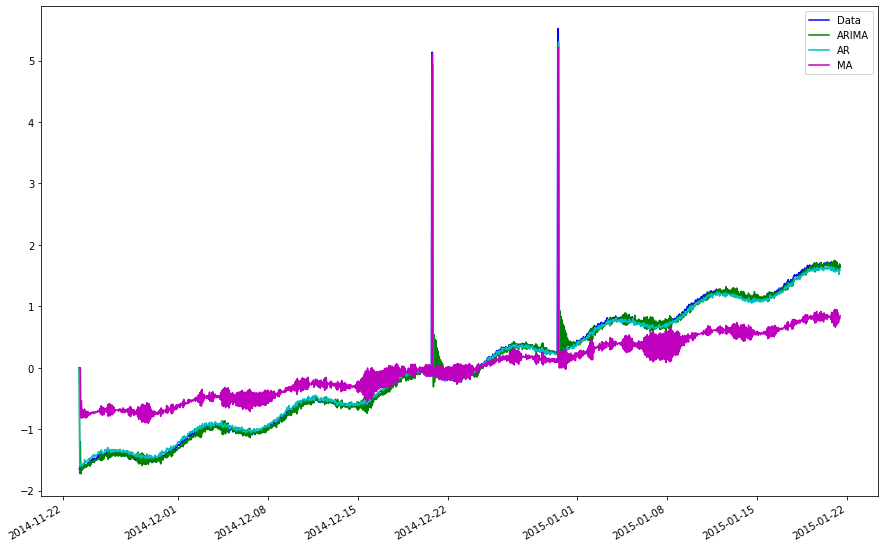

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:2 |True Negative: 1417
Total Positives(Anomalies):4 | Total Negatives(Regulars): 1417
Processing index: 30 of 100



Mean: 68.708294, StandardDeviation: 984.090053


/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


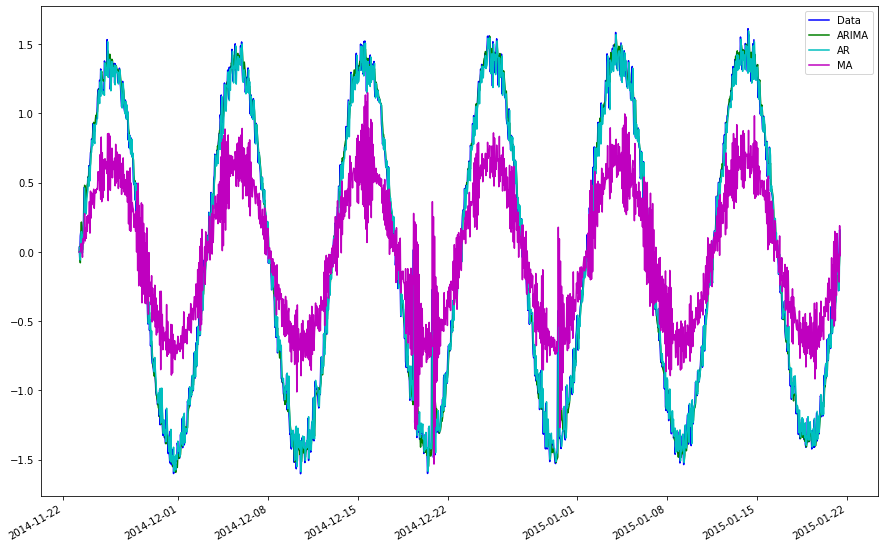

ARIMA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:3 | False Positive: 0
Negative:False Negative:6 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

AR Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:2 | False Positive: 0
Negative:False Negative:7 |True Negative: 1412
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412

MA Confusion Matrix:
Classes
Positive 	|	 Negative
Positive:True Positive:0 | False Positive: 18
Negative:False Negative:9 |True Negative: 1394
Total Positives(Anomalies):9 | Total Negatives(Regulars): 1412


In [124]:
start_time = datetime.now() 

arimaf1_plot = []
arimaprecision_plot = []
arimarecall_plot = []

arf1_plot = []
arprecision_plot = []
arrecall_plot = []

maf1plot = []
maprecision_plot = []
marecall_plot = []

for index,file in enumerate(all_csv):
    
    if index%5 == 0:
        print(f'Processing index: {index} of {len(all_csv)}')
    if index > 30:
         break
    print("\n\n")
    fname = file.split("/")[5].replace('\\','').split(".")[0]
    df = pd.read_csv(file)
    df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
    df_indexed = df.set_index('timestamp')
    #print(df_indexed)
    
    # prepare data for standardization
    values = df_indexed.copy()
    values = values.drop(columns=['is_anomaly'],axis=1)
    #values = values.reshape((len(values), 1))
    # train the standardization
    scaler2 = StandardScaler()
    scaler2 = scaler2.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler2.mean_, sqrt(scaler2.var_)))
    # standardize the dataset
    standardaized = scaler2.transform(values)

    df['std_value'] = standardaized
    df_indexed['std_value'] = standardaized
    #print("Data Standardized")
    
    #Checking the number of anomalies in the TS
    p = len(df[df.is_anomaly == 1])
    n = len(df[df.is_anomaly == 0])
    #print(f"Anomalies in Dataset: {p} \nNormal Records: {n}")
    
    arima = sarimax.SARIMAX(df.std_value,order=(7,1,7),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,)

    AR = sarimax.SARIMAX(df.std_value,order=(1,0,0),seasonal_order=(0,0,0,0),
                                     enforce_stationarity=False, enforce_invertibility=False,)

    MA = sarimax.SARIMAX(df.std_value,order=(0,0,1),seasonal_order=(0,0,0,0),
                                     enforce_stationarity=False, enforce_invertibility=False,)

    model = arima.fit()

    model2 = AR.fit()

    model3 = MA.fit()
    
    df1 = model.predict()
    df2 = model2.predict()
    df3 = model3.predict()
    
    #Plotting Models
    plt.rcParams.update({'figure.figsize': (15,10)})
    plt.plot_date(df['timestamp'],np.asarray(df['std_value']),'b-')

    plt.plot_date(df['timestamp'],np.asarray(df1), 'g-')

    plt.plot_date(df['timestamp'],np.asarray(df2), 'c-')

    plt.plot_date(df['timestamp'],np.asarray(df3), 'm-')

    plt.xlabel="Date"
    plt.ylabel="Server Traffic"
    plt.gcf().autofmt_xdate()
    plt.legend(('Data','ARIMA', 'AR', 'MA'))
    plt.show()
    
    #calculating confusion matrix
    comparisonmatrix = pd.concat([df,df1,df2,df3],axis = 1) #, on='timestamp',how='inner',lsuffix='_data',rsuffix='_predict')
    comparisonmatrix.rename(columns={0:'ARIMAval'},inplace=True)
    comparisonmatrix.rename(columns={1:'ARval'},inplace=True)
    comparisonmatrix.rename(columns={2:'MAval'},inplace=True)
    
    #manual threshold set
    threshold = 1.0

    #compare the real df std value with the predicted model value and then 
    arimaoutliers = comparisonmatrix[comparisonmatrix.std_value > comparisonmatrix.ARIMAval + threshold]
    aroutliers = comparisonmatrix[comparisonmatrix.std_value > comparisonmatrix.ARval + threshold]
    maoutliers = comparisonmatrix[comparisonmatrix.std_value > comparisonmatrix.MAval + threshold]
    
    arimanot_outliers = comparisonmatrix.merge(arimaoutliers, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'] 
    arnot_outliers = comparisonmatrix.merge(aroutliers, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'] 
    manot_outliers = comparisonmatrix.merge(maoutliers, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'] 
    
    
    arimatruepositives = arimaoutliers[arimaoutliers['is_anomaly'] == 1]
    arimafalsepostives = arimaoutliers[arimaoutliers['is_anomaly'] == 0]

    artruepositives = aroutliers[aroutliers['is_anomaly'] == 1]
    arfalsepostives = aroutliers[aroutliers['is_anomaly'] == 0]

    matruepositives = maoutliers[maoutliers['is_anomaly'] == 1]
    mafalsepostives = maoutliers[maoutliers['is_anomaly'] == 0]
    
    arimatruenegatives=arimanot_outliers[arimanot_outliers['is_anomaly'] == 0]
    arimafalsenegatives = arimanot_outliers[arimanot_outliers['is_anomaly'] == 1]

    artruenegatives=arnot_outliers[arnot_outliers['is_anomaly'] == 0]
    arfalsenegatives = arnot_outliers[arnot_outliers['is_anomaly'] == 1]

    matruenegatives=manot_outliers[manot_outliers['is_anomaly'] == 0]
    mafalsenegatives = manot_outliers[manot_outliers['is_anomaly'] == 1]
    
    print("ARIMA Confusion Matrix:")
    print("Classes")
    print("Positive \t|\t Negative")
    print(f"Positive:True Positive:{len(arimatruepositives)} | False Positive: {len(arimafalsepostives)}")
    print(f"Negative:False Negative:{len(arimafalsenegatives)} |True Negative: {len(arimatruenegatives)}")
    print(f"Total Positives(Anomalies):{p} | Total Negatives(Regulars): {n}")
    print()
    print("AR Confusion Matrix:")
    print("Classes")
    print("Positive \t|\t Negative")
    print(f"Positive:True Positive:{len(artruepositives)} | False Positive: {len(arfalsepostives)}")
    print(f"Negative:False Negative:{len(arfalsenegatives)} |True Negative: {len(artruenegatives)}")
    print(f"Total Positives(Anomalies):{p} | Total Negatives(Regulars): {n}")
    print()
    print("MA Confusion Matrix:")
    print("Classes")
    print("Positive \t|\t Negative")
    print(f"Positive:True Positive:{len(matruepositives)} | False Positive: {len(mafalsepostives)}")
    print(f"Negative:False Negative:{len(mafalsenegatives)} |True Negative: {len(matruenegatives)}")
    print(f"Total Positives(Anomalies):{p} | Total Negatives(Regulars): {n}")
    
    
    